# Introduction

In this notebook two datasets provided by the Austin Animal Shelter are analyzed. This notebook is split into five main parts:
1. Importing the libraries and the data
    The data is imported using the Socrata open API library
2. Data Cleansing and Wrangling
3. Plotting to understand the data: In this part several plots are introduced in order to answer the following research questions:
  - 3.1 What type of dogs are generally available for adoption in the Austin Animal Shelter?
  - 3.2 What factors may influence the time to adoption (an animal spends in the shelter before being adopted) and how do they influence?
4. Conclusions

# 1. Importing the libraries and data

In [10]:
import pandas as pd
import json
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata
import re
import numpy as np

In [11]:
#Trying out the SODAPY library and importing API directly

#intakes
#Intakes represent the status of animals as they arrive at the Animal Center
my_data = requests.get('https://data.austintexas.gov/resource/wter-evkm.json?$limit=170000&').content
my_list_shelter = json.loads(my_data)
intakes = pd.DataFrame(my_list_shelter)

#outcomes
#Outcomes represent the status of animals as they leave the Animal Center
my_data2 = requests.get('https://data.austintexas.gov/resource/9t4d-g238.json?$limit=170000&').content
my_list_shelter2 = json.loads(my_data2)
outcomes = pd.DataFrame(my_list_shelter2)

#Merging both the intakes and outcomes dataset on 'animal_id' to later on calculate difference in time to adoption.
both2 = intakes.merge(outcomes, on='animal_id', how='left')

# 2. Data cleansing and wrangling

2.1 Exploring the dataset

In [12]:
both2.describe()

,animal_id,datetime_x,datetime2,found_location,intake_type,intake_condition,animal_type_x,sex_upon_intake,age_upon_intake,breed_x,...,monthyear,date_of_birth,outcome_type,outcome_subtype,animal_type_y,sex_upon_outcome,age_upon_outcome,breed_y,color_y,name_y
count,156689,156689,156689,156689,156689,156689,156689,156689,156689,156689,...,155914,155914,155908,60691,155914,155914,155914,155914,155914,117134
unique,108171,85290,85290,52499,6,10,5,6,51,2596,...,99146,6971,9,23,5,6,52,2591,585,19230
top,A721033,2016-09-23T12:00:00.000,2016-09-23T12:00:00.000,Austin (TX),Stray,Normal,Dog,Intact Male,1 year,Domestic Shorthair Mix,...,2016-04-18T00:00:00.000,2015-05-20T00:00:00.000,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White,Lil Bit
freq,1089,73,73,32225,104230,139778,99551,45741,29013,34007,...,57,1131,69918,32842,99268,60492,29257,33910,17017,1103


In [13]:
both2.dtypes

animal_id           object
datetime_x          object
datetime2           object
found_location      object
intake_type         object
intake_condition    object
animal_type_x       object
sex_upon_intake     object
age_upon_intake     object
breed_x             object
color_x             object
name_x              object
datetime_y          object
monthyear           object
date_of_birth       object
outcome_type        object
outcome_subtype     object
animal_type_y       object
sex_upon_outcome    object
age_upon_outcome    object
breed_y             object
color_y             object
name_y              object
dtype: object

2.2 Adjusting types of the variables

In [14]:
both2["intake_date"]  = pd.to_datetime(both2["datetime_x"]).dt.date
both2["outcome_date"] = pd.to_datetime(both2["datetime_y"]).dt.date
both2["monthyear"] = pd.to_datetime(both2["monthyear"]).dt.date
both2["date_of_birth"] = pd.to_datetime(both2["date_of_birth"]).dt.date

2.3 Filling missing data

In [ ]:
# Missing data is replaced with '0' in order for the difference in days to adoption to be calculated.
both2['datetime2'] = both2['datetime2'].fillna(0)
both2['date_of_birth'] = both2['date_of_birth'].fillna(0)

#Replacing NaN's in outcome_date and outcome_type
text = "Not Adopted"
both2["outcome_date"].fillna(value=0, inplace=True)
both2["outcome_type"].fillna(value=text, inplace=True)

2.4 Dropping unnecessary data points

In [15]:
#From the data it appeared some animals enter the animal shelter multiple times in their lives. The first time the animal entered the shelter is kept in all data entries. Therefore only the most recent intake and outcome of that animal are kept.
both2.drop_duplicates(subset=['animal_id', 'datetime_x'], inplace=True)

#Dropping all other animals besides 'Dogs'
df = both2[both2["animal_type_x"] == 'Dog']

In [ ]:
df['intake_date'].astype('string')

2.5 Creating new variable for calculation Days to Adoption

In [16]:
#To create this variable. The intake date (incoming) is substracted from the outcome date(when the animal leaves) in order to define the number of days spend in the shelter. This value is changed to string.
df['diff'] = (df.loc[:,('outcome_date')] - df.loc[:,('intake_date')]).apply(str)
df.drop(df[df.loc[:,"diff"].str.startswith("-")].index, inplace=True)
#Replace '0'-values
df["diff"].replace({pd.NaT: "0 days"}, inplace=True)

/Users/elskedenbode/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/elskedenbode/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/elskedenbode/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

2.6 Creating a dataset with only dogs that were Adopted (as per their outcome type)

In [44]:
df2 = df['outcome_type']=='Adoption'
df3 = df[df2]
df3

,animal_id,datetime_x,datetime2,found_location,intake_type,intake_condition,animal_type_x,sex_upon_intake,age_upon_intake,breed_x,...,age_upon_outcome,breed_y,color_y,name_y,intake_date,outcome_date,diff,age_upon_intake_(years),diff_indays,count
55,A823083,2020-10-01T17:29:00.000,2020-10-01T17:29:00.000,Austin (TX),Owner Surrender,Normal,Dog,Female,3 years,Labrador Retriever/Pit Bull,...,3 years,Labrador Retriever/Pit Bull,Black/White,*Annie,2020-10-01,2020-10-01,0 days 00:00:00,3.0,0,1
119,A809343,2020-09-30T15:43:00.000,2020-09-30T15:43:00.000,Austin (TX),Owner Surrender,Normal,Dog,Male,1 year,Labrador Retriever/German Shepherd,...,1 year,Labrador Retriever/German Shepherd,Brown,Sage,2020-09-30,2020-10-01,1 days 00:00:00,1.0,1,1
152,A823759,2020-09-29T17:46:00.000,2020-09-29T17:46:00.000,6001 Shepherd Mountain Cove in Austin (TX),Stray,Normal,Dog,Male,2 years,Pug/Beagle,...,2 years,Pug/Beagle,Brown,<NA>,2020-09-29,2020-10-02,3 days 00:00:00,2.0,3,1
168,A823735,2020-09-29T13:38:00.000,2020-09-29T13:38:00.000,Austin (TX),Owner Surrender,Normal,Dog,Male,9 months,Alaskan Husky/German Shepherd,...,9 months,Alaskan Husky/German Shepherd,Tan/White,Oro,2020-09-29,2020-10-01,2 days 00:00:00,9.0,2,1
207,A823673,2020-09-28T14:52:00.000,2020-09-28T14:52:00.000,Austin (TX),Owner Surrender,Normal,Dog,Female,5 months,Pit Bull/Australian Cattle Dog,...,5 months,Pit Bull/Australian Cattle Dog,Brown Brindle/White,Queenie,2020-09-28,2020-09-30,2 days 00:00:00,5.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156659,A664274,2013-10-01T13:48:00.000,2013-10-01T13:48:00.000,Austin (TX),Owner Surrender,Normal,Dog,Female,8 years,Siberian Husky Mix,...,8 years,Siberian Husky Mix,Buff,Estrella,2013-10-01,2013-10-11,10 days 00:00:00,8.0,10,1
156663,A664273,2013-10-01T13:32:00.000,2013-10-01T13:32:00.000,Berkman Dr & Briarcliff Blvd in Austin (TX),Stray,Normal,Dog,Female,1 year,Dachshund/Chihuahua Shorthair,...,1 year,Dachshund/Chihuahua Shorthair,Brown,Buffy,2013-10-01,2013-10-13,12 days 00:00:00,1.0,12,1
156672,A664269,2013-10-01T11:28:00.000,2013-10-01T11:28:00.000,7500 S Ih 35 in Austin (TX),Stray,Normal,Dog,Male,2 years,Great Pyrenees Mix,...,2 years,Great Pyrenees Mix,White,*Bismark,2013-10-01,2013-10-19,18 days 00:00:00,2.0,18,1
156674,A651630,2013-10-01T11:23:00.000,2013-10-01T11:23:00.000,Outside Jurisdiction,Owner Surrender,Injured,Dog,Female,6 years,Labrador Retriever/Chinese Sharpei,...,6 years,Labrador Retriever/Chinese Sharpei,Tan,Heather,2013-10-01,2013-12-31,91 days 00:00:00,6.0,91,1


In [18]:
#Taking the number of years and difference in days from object variable. Extracting the number and turning it into string value.
df['age_upon_intake_(years)'] = df.loc[:,'age_upon_intake'].str.extract(r'(\d+)')
df['diff_indays'] = df.loc[:,'diff'].str.extract(r'(\d+)')
df.dropna(subset=['diff_indays'], inplace=True)
df['age_upon_intake_(years)'] = df.loc[:,'age_upon_intake_(years)'].astype(float)

/Users/elskedenbode/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/elskedenbode/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/elskedenbode/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [29]:
#transforming variables to appropriate format
df = df.astype('string')
df.dtypes
df["count"] = 1

import matplotlib.dates as mdates
df["age_upon_intake_(years)"] = df["age_upon_intake_(years)"].astype(float)

In [20]:
# Changing gender types into two categories: leaving spayed, neutered and intact outside of the scope of this analysis - which could have an influence.
df.loc[(df.sex_upon_intake == 'Spayed Female'),'sex_upon_intake']='Female'
df.loc[(df.sex_upon_intake == 'Neutered Male'),'sex_upon_intake']='Male'
df.loc[(df.sex_upon_intake == 'Intact Female'),'sex_upon_intake']='Female'
df.loc[(df.sex_upon_intake == 'Intact Male'),'sex_upon_intake']='Male'
df.loc[(df.sex_upon_intake == 'Null'),'sex_upon_intake']='Unknown'
df.loc[(df.sex_upon_intake == 'NULL'),'sex_upon_intake']='Unknown'
df.sex_upon_intake.value_counts()

Male       36409
Female     31265
Unknown      446
Name: sex_upon_intake, dtype: Int64

# 3.1 What type of dogs are generally available for adoption in the Austin Animal Shelter?

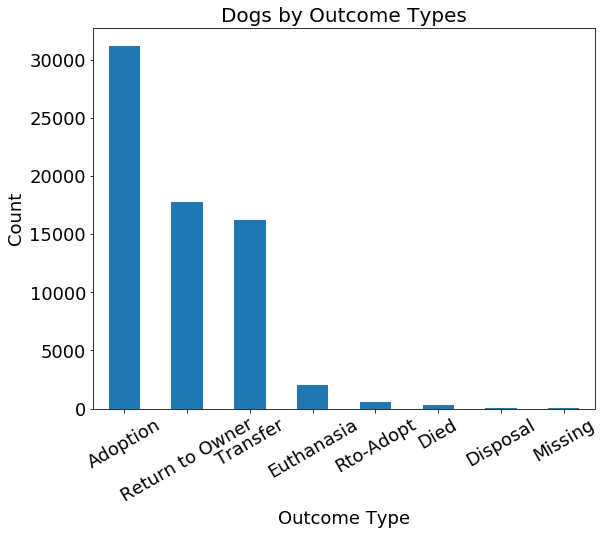

In [21]:
#In order to understand what happens when the dogs leave the shelter (categorical variable) I use a bar plot.

df["outcome_type"].value_counts().plot(kind='bar', figsize=(9, 7))
plt.title('Dogs by Outcome Types', fontsize=20);
plt.xlabel('Outcome Type', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=18)
plt.xticks(rotation=30)
plt.yticks(fontsize=18);

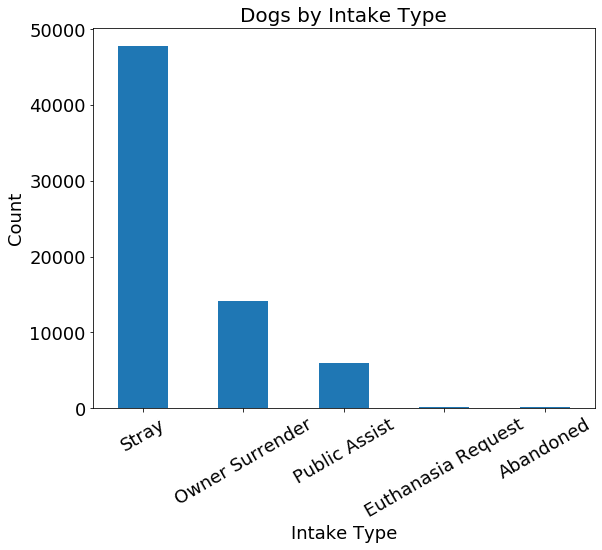

In [22]:
#In order to understand for which reason dogs enter the shelter (categorical variable) I use a bar plot.

df["intake_type"].value_counts().plot(kind='bar', figsize=(9, 7))
plt.title('Dogs by Intake Type', fontsize=20);
plt.xlabel('Intake Type', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=18)
plt.xticks(rotation=30)
plt.yticks(fontsize=18);

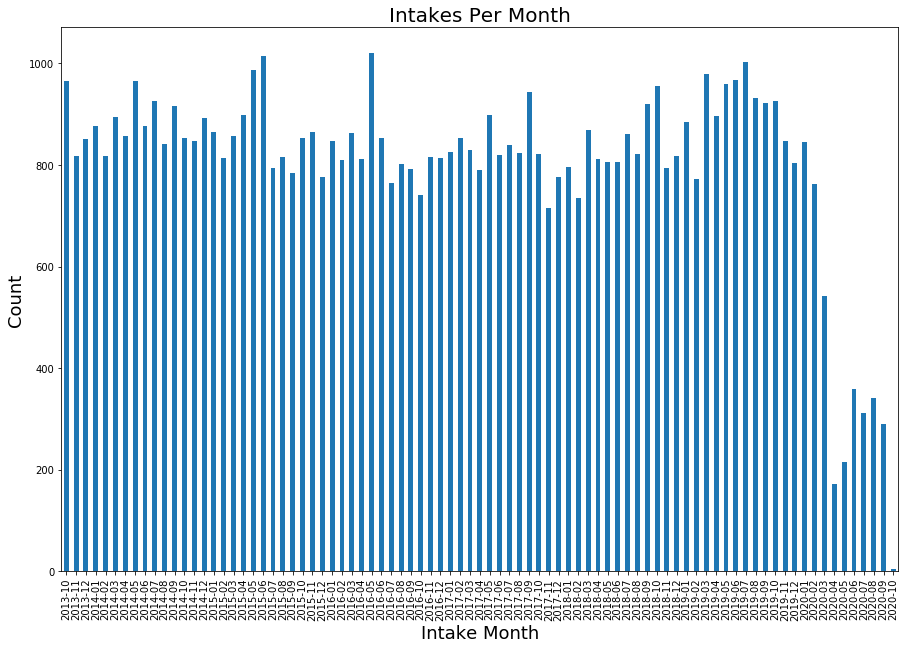

In [90]:
#When do the dogs enter the shetler?
df['intake_date'] = pd.to_datetime(df['intake_date'])
df['intake_date_month'] = df['intake_date'].dt.to_period('M')
df['intake_date_month'].value_counts().sort_index().plot.bar(figsize=[15,10])
plt.title('Intakes Per Month', fontsize=20);
plt.xlabel('Intake Month', fontsize=18)
plt.ylabel('Count', fontsize=18);

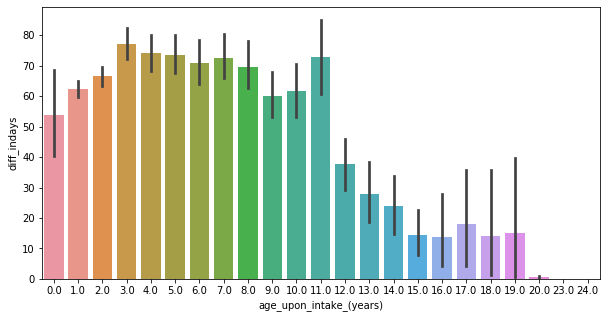

In [26]:
x=df['diff_indays'].astype(float)
y=df['age_upon_intake_(years)'].astype(float)
plt.figure(figsize=(10,5))
sns.barplot(data=df, x=y, y=x)
#plt.title('Animal Type Average Age Upon Intake', fontsize=20);
#plt.xlabel('Animal Type', fontsize=18)
#plt.ylabel('Age (Years)', fontsize=18);

In [83]:
#The above plot shows that older dogs generally have shorter amount of time spend in the shelter. 
#Further analysis is needed to explain why this phenomenon appears according to this plot

/Users/elskedenbode/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Top 20 Dog Breeds')

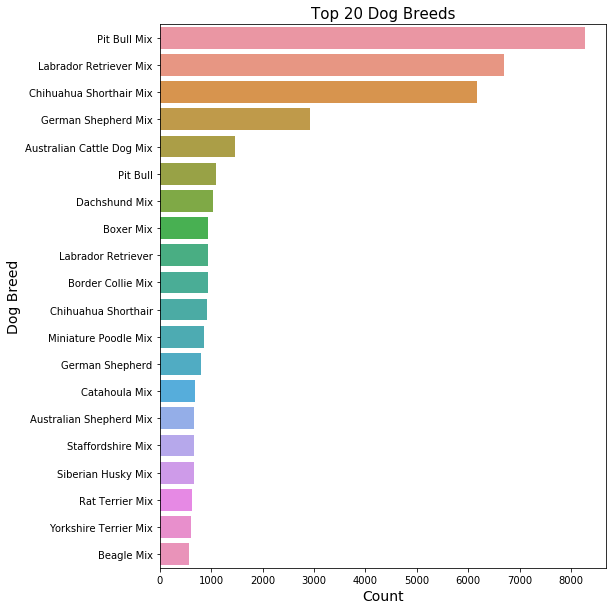

In [81]:
#To plot the frequency of dog breeds of dogs in the shelter a groupby is created and the top 20 (For readability) is chosen
breed = df.groupby(['breed_x'])['count'].sum().reset_index().sort_values(by='count', ascending=False)
top = breed.head(20)

#The top 20 is plotted
fig = plt.figure(figsize=(8,10))
sns.barplot('count','breed_x', data=top, linewidth=0.7)
plt.ylabel('Dog Breed', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.title('Top 20 Dog Breeds', fontsize=15)

In [36]:
#The top three breeds Pit Bull Mix, Labrador Retriever Mix, and Chichuaha Shorthair Mix are quite dominant in terms of count.
#In addition it can be noted that mostly "mixes" of breeds appear in the Animal Center as opposed to full breeds

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='intake_type', y='age_upon_intake_(years)', hue='sex_upon_intake', data=df, orient='v')
plt.title('Age Distributions for Intake Type', fontsize=20);
plt.xlabel('Intake Type', fontsize=18)
plt.ylabel('Age (Years)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='intake_condition', y='age_upon_intake_(years)', data=df, orient='v')
plt.title('Age Distributions for Intake Condition', fontsize=20);
plt.xlabel('Intake Type', fontsize=18)
plt.ylabel('Age (Years)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

# 3.2 What factors may influence the time to adoption (an animal spends in the shelter before being adopted) and how do they influence?

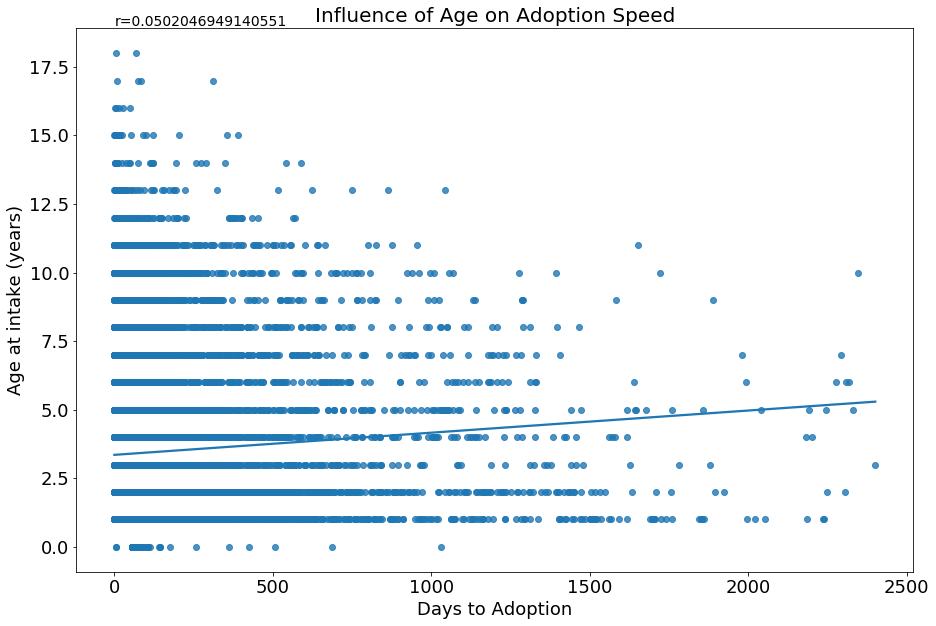

In [46]:
#ensure variables in the right format and calculate correlation
x = df3["age_upon_intake_(years)"].astype(float)
y = df3["diff_indays"].astype(float)
corr = x.corr(y)
#set figure size
plt.figure(figsize=(15, 10))
#plot the data
sns.regplot(data=df3,x=y,y=x, ci=None)
#format the plot
text = 'r=%s' % (corr)
plt.text(1, 19, text, fontsize=14)
plt.title('Influence of Age on Adoption Speed', fontsize=20);
plt.xlabel('Days to Adoption', fontsize=18)
plt.ylabel('Age at intake (years)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

In [47]:
#The above plot shows a weak though positive  correlation between age and days to adoption. This means that older dogs tend to take longer before being adopted.
#It is important to note here that the outcome type was set to Adoption. Thus, return to owner, euthanasia, death and transferred animals are not taken into consideration to only focus on adoption.

(0, 50)

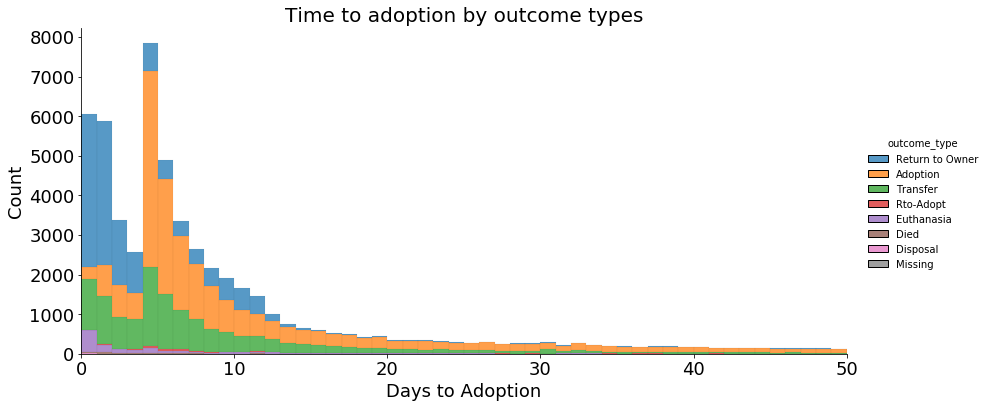

In [48]:
#ensure right type of the variable
x = df['diff_indays'].astype(float)
#plotting distribution of adoption time by outcome types, may show differences in days to adoption remembering not all dogs were adopted (seen in the barplots whilst exploring the data)
sns.displot(df, x=x, binwidth=1, height=5.27, aspect=11.7/5.27, hue='outcome_type', multiple='stack')
#formatting the plot
plt.title('Time to adoption by outcome types', fontsize=20);
plt.xlabel('Days to Adoption', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.xlim(0,50)

In [ ]:
#The above plot clearly visualizes that the outcome type influences the days to adoption. 
#For example, 'Return to Owner' happens much quicker than an adoption. This makes sense as owners regularly 
#instantly fetch their dogs when they are found and checked into the shelter. An adoption, as seen by the
#later peak around 7 days, takes longer.

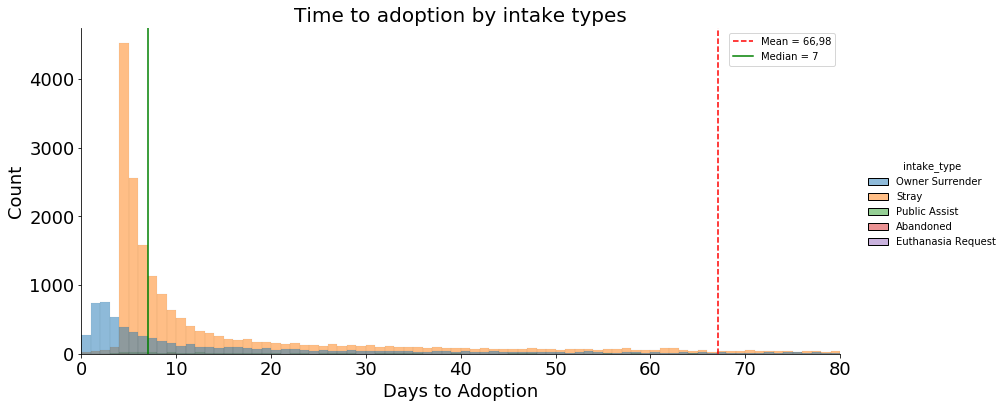

In [52]:
#ensuring variables in right format
x = df['diff_indays'].astype(float)
#calculating info such as mean and median.
mean=x.mean()
median=x.median()
#plotting the data
sns.displot(data=df3, x=x, binwidth=1, height=5.27, aspect=11.7/5.27, hue='intake_type')
#A limit on the x-axis was set in order for the plot to maintain readability
plt.xlim(0,80)
#Formatting the chart
plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='-')
plt.title('Time to adoption by intake types', fontsize=20);
plt.xlabel('Days to Adoption', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);
plt.legend({'Mean = 66,98':mean,'Median = 7':median})
plt.show()

In [ ]:
#This plot shows the days to adoption is generally short, shorter than or just slightly longer than 10 days.
#Which is also backed by the calculated median of 7 days.
#However, the mean is 66.98 meaning that shows that the distribution is very unequally distributed.
#Hence, some dogs in the animal shelter stay a much longer amount of time in the shelter before being adopted.
#Finally, the intake types explain that the above is mostly the case for stray dogs.
#For owner surrender (owners that bring in the dog to rehome them) dogs the peak is even earlier.

# 5. Conclusions

-With regards to breeds: mostly mixes of breeds are found in the shelter.

-The largest part of dogs entering the shelter are Stray dogs, followed by owner surrender.

-Older dogs are more likely to enter the shelter for Euthanasia (which makes sense)

-Older dogs tend to take longer to get adopted.Further analysis needs to statiscically find proof for this.

-Dogs with intake type 'owner surrender' tend to get adopted at a quicker speed.

-There seem to be some peak and lows in terms of months that dogs come into the shelter